# Homework 1

* Related with the nature of the data, which conditions should meet matrices $A$ and $b$ to be solvable from the least squares perspective.

* Use a least squares for non-linear models adjust the bitcoin price and perform a prediction using the model to determine the future daily price a week ahead, compare with the actual values.

* Use least squares to determine the relationship between the bitcoin price and prices of three comodities namely, oil, silved and gold, during the last year.

* Solve the [point set registration problem](https://en.wikipedia.org/wiki/Point-set_registration). Hint (check: S. Umeyama, Least-Squares Estimation of Transformation Parameters Between Two Point Patterns, IEEE Trans. Pattern Anal. Mach. Intell., vol. 13, no. 4, 1991). Construct a GUI to test. (**Additional points**)

### 1. Least squares solution $A$ & $b$ conditions 
El problema de ajuste de datos mediante un modelo se puede resolver mediante la minimización de cuadrados de la siguiente forma:

$$\tilde{x} = \mbox{arg min}_{x} \| Ax - b \|_2^2$$ 
En donde la matriz $A$ "codifica" la naturaleza del modelo, $x$ son los parametros y $b$ son las predicciones.

Expandiendo esta expresion e igualando a cero el gradiente(para hallar el minimo de la función) llegamos a la ecuación normal: $$A^T A x = A^T b$$

Ahora bien, ¿Para que $A$ y $b$ tiene solución esta ecuación? 

Si las columnas de $A$ son linearmente independientes, entonces $(A^T A)^{-1}$ existe y la solución se puede calcular mediante $$x = (A^T A)^{-1} A^T b$$¿Es esta solución unica?

Si las columnas de $A$ **NO** son linearmente independientes, entonces la ecuación se puede solucionar mediante descomposición ortogonal, por ejemplo descomposición QR o SVD.

Por lo tanto, las ecuaciones normales siempre tienen solución y por lo tanto el problema de los minimos cuadrados lineales es solucionable.

### 2. Linear Least Squares with Non Linear Model
Los datos de Bitcoin fueron tomados de [CryptoDataDownload](https://www.cryptodatadownload.com/data/gemini/).
 
Ahora se va a usar un modelo no lineal para explicar el precio del Bitcoin, especificamente se va modelar mediante un polinomio de grado 5:
$$f(x) = ax^5 + bx^4 + cx^3 + dx^2 + ex + g$$

In [1]:
using CSV
using DataFrames
using Plots
using TimeSeries
using LinearAlgebra

Load the Bitcoin dataset

In [14]:
btc_ds = select(CSV.read("Gemini_BTCUSD_day.csv", DataFrame), Not(["Unix Timestamp", "Symbol", "Volume"]));
btc_ds.Date = broadcast(d -> Date(d[1:length(d)-9]), btc_ds.Date) # parse dates
n = 60
btc_ds = btc_ds[1:n,:]; 

In [15]:
first(btc_ds, 5)

,Date,Open,High,Low,Close
,Date,Float64,Float64,Float64,Float64
1,2022-03-17,41025.5,41471.6,40283.1,40592.0
2,2022-03-16,39177.7,41471.6,38950.0,41025.5
3,2022-03-15,38767.4,41702.9,38110.2,39177.7
4,2022-03-14,38167.6,39917.2,38130.8,38767.4
5,2022-03-13,39193.8,39309.1,37578.1,38167.6


Bitcoin time series plot for the last n days

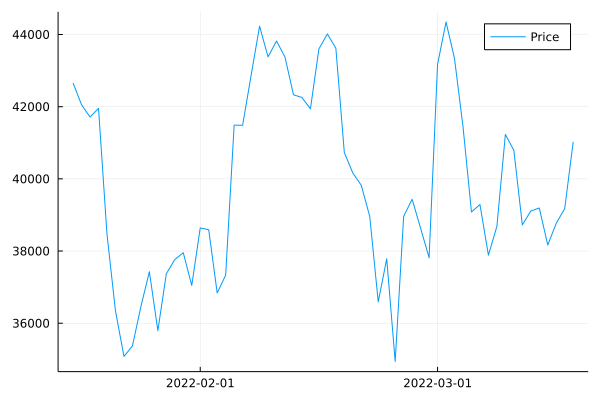

In [17]:
data = (date = btc_ds.Date, BTC_Price = btc_ds.Open)
ta = TimeArray(data; timestamp = :date, meta = "btc")
Plots.plot(ta)

Matrix representation of system

In [3]:
btc_prices = btc_ds.Open
A = [Array(1:n) ones(n,1)] 
b = Array(btc_prices);

Plot of the objective function $f:\mathbb{R}^2 \to \mathbb{R}$ defined by $f(x) = \| Ax - b \|_2^2$

Computing the solution $ x = (A^T A)^{-1} A^T b$

In [4]:
@time inv(transpose(A)*A)*transpose(A)*b

  1.227487 seconds (3.79 M allocations: 191.844 MiB, 4.61% gc time, 86.57% compilation time)


2-element Vector{Float64}:
   -15.582590441789307
 40317.0748418079

Moore Penrose pseudoinverse

In [5]:
@time pinv(A)*b

  0.954254 seconds (2.47 M allocations: 132.162 MiB, 3.14% gc time, 95.75% compilation time)


2-element Vector{Float64}:
   -15.582590441789762
 40317.07484180791

Solving the normal equations $A^T A x = A^T b$ directly using Julia's backslash operator

In [6]:
@time transpose(A)*A \ transpose(A)*b

  0.706987 seconds (1.93 M allocations: 97.963 MiB, 4.36% gc time, 99.98% compilation time)


2-element Vector{Float64}:
   -15.582590441790046
 40317.07484180792

In [7]:
@time A \ b

  0.216659 seconds (520.25 k allocations: 27.424 MiB, 13.64% gc time, 99.92% compilation time)


2-element Vector{Float64}:
   -15.582590441789721
 40317.074841807924

Solving(Approximating) the overdetermined system directly using backslash operator

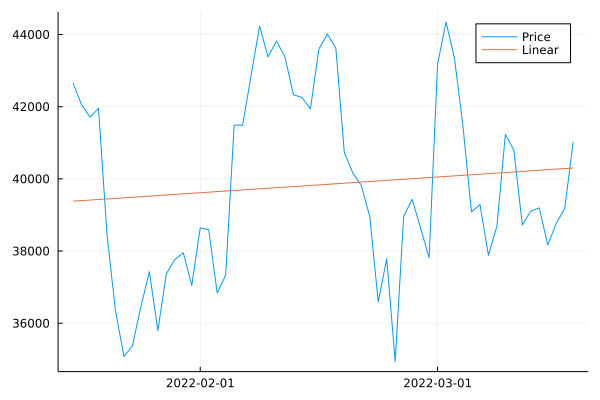

In [19]:
m, b1 = A \ b
pred(x) = m*x + b1
xs = range(1, n)
data = pred.(xs)
plot!(btc_ds.Date, data, label="Linear")

**Polynomial model**

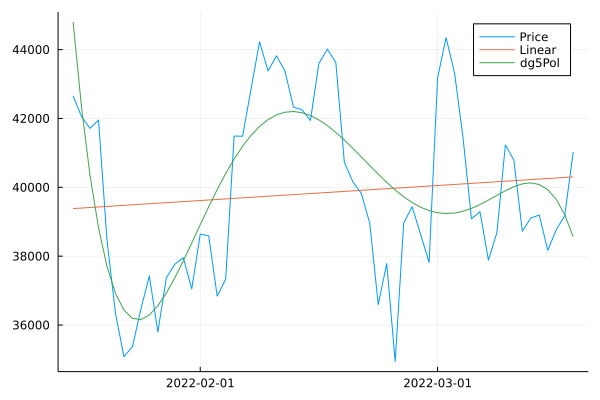

In [20]:
# ax⁵ + bx⁴ + cx³ + dx² + ex + f 
x = Array(1:n)
A = [x.^5 x.^4 x.^3 x.^2 x ones(n)]
a, b, c, d, e, f = A \ b
quint(x) = a*x^5 + b*x^4 + c*x^3 + d*x^2 + e*x + f

xs = range(1, n)
data = quint.(xs)
plot!(btc_ds.Date, data, label="dg5Pol")

In [39]:
last_date = maximum(btc_ds.Date)
days = [last_date + Dates.Day(i) for i in 1:8]
prices = quint.(Array(36:43))
[days prices]

8×2 Matrix{Any}:
 2022-03-18  42104.5
 2022-03-19  41967.5
 2022-03-20  41769.6
 2022-03-21  41511.2
 2022-03-22  41193.9
 2022-03-23  40821.3
 2022-03-24  40398.6
 2022-03-25  39933.1

### 3. BTC relationship with other commodities

Historical data for:

- [**Gold**](https://www.nasdaq.com/market-activity/commodities/gc:cmx/historical) in Troy Oz

- [**Silver**](https://www.nasdaq.com/market-activity/commodities/si:cmx/historical) in Troy Oz

- [**Oil**](https://www.nasdaq.com/market-activity/commodities/cl:nmx/historical) WTI Barrel

In [32]:
gold_ds = select(CSV.read("GoldUSD_ds.csv", DataFrame), Not(["Volume"]))
silver_ds = select(CSV.read("SilverUSD_ds.csv", DataFrame), Not(["Volume"]))
oil_ds = select(CSV.read("OilUSD_ds.csv", DataFrame), Not(["Volume"]))

str2date(date) = Date(date, dateformat"m/d/y")

gold_ds.Date = str2date.(gold_ds.Date)
silver_ds.Date = str2date.(silver_ds.Date)
oil_ds.Date = str2date.(oil_ds.Date);

gold_ta = TimeArray()

In [36]:
gold_ta = TimeArray(gold_ds.Date, gold = gold_ds.Open)
Plots.plot(gold_ta)

LoadError: UndefKeywordError: keyword argument timestamp not assigned